In [20]:
from keras import models, backend, datasets, utils
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, Activation, UpSampling2D, BatchNormalization, Concatenate
import matplotlib.pyplot as plt
import numpy as np

# UNET 모델링 

In [9]:
class UNET(models.Model):
    def __init__(self, org_shape, n_ch):
        ic = 3 if backend.image_data_format() == "channels_last" else 1 
        # 이미지데이터 포맷을보면, (3, 100, 100) 혹은 (100, 100, 3) 이렇게 다를 수 있음.
        # backend 라는 기능을 쓰면 채널이 마지막에있는지 앞에있는지 알려줌. 
        # 배치, 높이, 너비, 채널 / 배치, 채널, 높이, 너비
        
        # 수축경로    
        def conv(x, n_f, mp_flag = True): # mp_flag : 맥스풀을 먼저 수행할 것 인지. n_f : 피쳐(커널) 몇 개 쓸건지.
            x = MaxPool2D((2, 2), padding = "same")(x) if mp_flag else x
            x = Conv2D(n_f, (3, 3), padding = "same")(x) # (3, 3) : 필터 크기
            x = BatchNormalization()(x) # 과대적합 방지
            x = Activation("tanh")(x) # 활성화 함수
            x = Dropout(0.05)(x)  #  BatchNormalization()(x) < 얘랑 같이쓰면 성능 구려짐 그래서 0.05만 넣음
            x = Conv2D(n_f, (3, 3), padding = "same")(x)
            x = BatchNormalization()(x)
            x = Activation("tanh")(x)
            return x

        # 확장경로
        def deconv_unet(x, e, n_f):
            x = UpSampling2D((2, 2))(x) # 가로 두배 세로 두배로 늘려줌
            x = Concatenate(axis = ic)([x, e]) # 앞에 전달받은것들과 연결
            x = Conv2D(n_f, (3, 3), padding = "same")(x) # 합성곱
            x = BatchNormalization()(x) # 과대적합 방지
            x = Activation("tanh")(x)
            x = Conv2D(n_f, (3, 3), padding = "same")(x)
            x = BatchNormalization()(x)
            x = Activation("tanh")(x)
            return x

        original = Input(shape = org_shape) # 입력층
        # Encoding
        c1 = conv(original, 16, mp_flag = False) # 채널 16짜리 conv 블럭에 집어넣기
        c2 = conv(c1, 32) # c1을 다시 채널 32 짜리 conv 블럭에 집어넣기

        encoded = conv(c2, 64) # 64의 채널로까지 인코딩 진행

        # Decoding 
        x = deconv_unet(encoded, c2, 32) # 업샘플링한거와 옆에서 끼어들어온애들까지
        x = deconv_unet(x, c1, 16)

        decoded = Conv2D(n_ch, (3, 3), activation= "sigmoid", padding = "same")(x) # 최종 결과물 내기

        super().__init__(original, decoded)
        self.compile(optimizer = "adadelta", loss = "mse")

# 데이터 준비

In [10]:
class DATA():
    def __init__(self, in_ch = None): # in_ch = 학습에 사용할 채널. 원본데이터엔 컬러가있음. 원본데이터를 정답값으로 씀.
        (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
        
        if x_train.ndim == 4: # 높이 , 너비, 채널로 들어가게.
            if backend.image_data_format() == "channels_first":
                n_ch, img_rows, img_cols = x_train.shape[1:]
            else:
                img_rows, img_cols, n_ch = x_train.shape[1:]
                
        else:
            img_rows, img_cols = x_train.shape[1:]
            n_ch = 1
            
        in_ch = n_ch if in_ch is None else in_ch
        
        x_train = x_train.astype("float32")
        x_test = x_test.astype("float32")
        x_train /= 255
        x_test /= 255
        
        # 컬러 -> 흑백 변환 함수
        def RGB2Gray(X, fmt):
            if fmt == "channels_first":
                R = X[:, 0:1] # 시리즈로 뽑으면 안되기때문에 (2차원이어야함) 차원정보유지를위해 굳이 슬라이싱으로 뽑음
                G = X[:, 1:2]
                B = X[:, 2:3]
            else:
                R = X[..., 0:1] # ... 은 이거 이 외의 모든 차원들을 말하는 것. 0:1을 제외한 나머지 전부 라는 뜻
                G = X[..., 1:2]
                B = X[..., 2:3]
            return 0.299 * R + 0.587 * G + 0.114 * B
        
        if backend.image_data_format() == "channels_first":
            x_train_out = x_train.reshape(x_train.shape[0], n_ch, img_rows, img_cols) 
            x_test_out = x_test.reshape(x_test.shape[0], n_ch, img_rows, img_cols)
            input_shape = (in_ch, img_rows, img_cols)
            
        else:
            x_train_out = x_train.reshape(x_train.shape[0], img_rows, img_cols, n_ch)
            x_test_out = x_test.reshape(x_test.shape[0],img_rows, img_cols, n_ch)
            input_shape = (img_rows, img_cols, in_ch)
            
        # 그레이 스케일 변환 적용
        if in_ch == 1 and n_ch == 3: # 훈련데이터로 쓰일게 흑백, 최종적으로 출력할 데이터는 컬러
            x_train_in = RGB2Gray(x_train_out, backend.image_data_format()) # 그레이스케일로 변환하면 훈련데이터로
            x_test_in = RGB2Gray(x_test_out, backend.image_data_format())
        else:
            x_train_in = x_train_out
            x_test_in = x_test_out
            
        # 인스턴스 변수 변환
        self.input_shape = input_shape
        self.x_train_in, self.x_train_out = x_train_in, x_train_out
        self.x_test_in, self.x_test_out = x_test_in, x_test_out
        self.n_ch = n_ch
        self.in_ch = in_ch

# 학습 

In [17]:
data = DATA(in_ch = 1)

In [18]:
unet = UNET(data.input_shape, data.n_ch)

In [19]:
history = unet.fit(data.x_train_in, data.x_train_out,
                  epochs = 10,
                  batch_size = 128,
                   shuffle = True,
                   validation_split = 0.2
                  )

Epoch 1/10

313/313 [==============================] - 71s 218ms/step - loss: 0.1003 - val_loss: 0.0831
Epoch 2/10
313/313 [==============================] - 64s 204ms/step - loss: 0.0701 - val_loss: 0.0579
Epoch 3/10
313/313 [==============================] - 63s 201ms/step - loss: 0.0541 - val_loss: 0.0478
Epoch 4/10
313/313 [==============================] - 62s 199ms/step - loss: 0.0459 - val_loss: 0.0421
Epoch 5/10
313/313 [==============================] - 60s 190ms/step - loss: 0.0411 - val_loss: 0.0385
Epoch 6/10
313/313 [==============================] - 58s 187ms/step - loss: 0.0379 - val_loss: 0.0359
Epoch 7/10
313/313 [==============================] - 63s 203ms/step - loss: 0.0356 - val_loss: 0.0340
Epoch 8/10
313/313 [==============================] - 62s 198ms/step - loss: 0.0339 - val_loss: 0.0325
Epoch 9/10
313/313 [==============================] - 69s 220ms/step - loss: 0.0324 - val_loss: 0.0312
Epoch 10/10
313/313 [==============================] - 65s 207ms/step - 

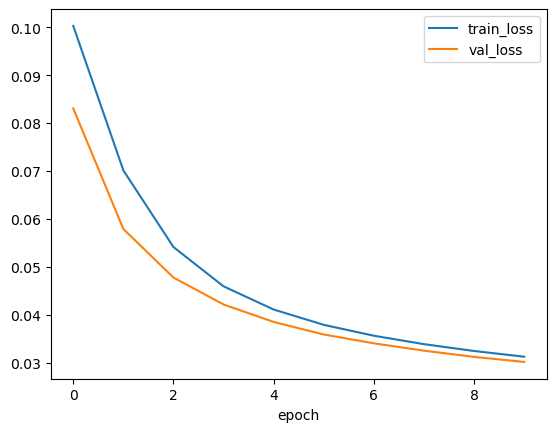

In [21]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["val_loss"], label = "val_loss")

plt.legend()
plt.xlabel("epoch")
plt.show()

In [26]:
def show_images(data, unet):
    x_test_in = data.x_test_in
    x_test_out = data.x_test_out
    decoded_imgs = unet.predict(x_test_in)
    
    if backend.image_data_format() == "channels_first":
        print(x_test_out.shape)
        x_test_out = x_test_out.swapaxes(1, 3).swapaxes(1, 2)
        print(x_test.shape)
        
        decoded_imgs = decoded_imgs.swapaxes(1, 3).swapaxes(1, 2)
        
        if data.in_ch == 1:
            x_test_in = x_test_in[:, 0, ...]
            
        elif data.in_ch == 2:
            print(x_test_out.shape)
            x_test_in_tmp = np.zeros_like(x_test_out)
            x_test_in = x_test_in.swapaxes(1, 3).swapaxes(1, 2)
            x_test_in_tmp[..., :2] = x_test_in
            x_test_in = x_test_tmp
            
        else:
            x_test_in = x_test_in.swapaxes(1, 3).swapaxes(1, 2)
    else:
        if data.in_ch == 1:
            x_test_in = x_test_in[..., 0]
        elif data.in_ch == 2:
            x_test_in_tmp = np.zeros_like(x_test_out)
            x_test_in_tmp[..., :2] = x_test_in
            x_test_in = x_test_in_tmp
            
    n = 10
    plt.figure(figsize = (20, 6))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test_in[i], cmap = "gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + n)
        plt.imshow(decoded_imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n * 2)
        plt.imshow(x_test_out[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

313/313 [==============================] - 6s 19ms/step


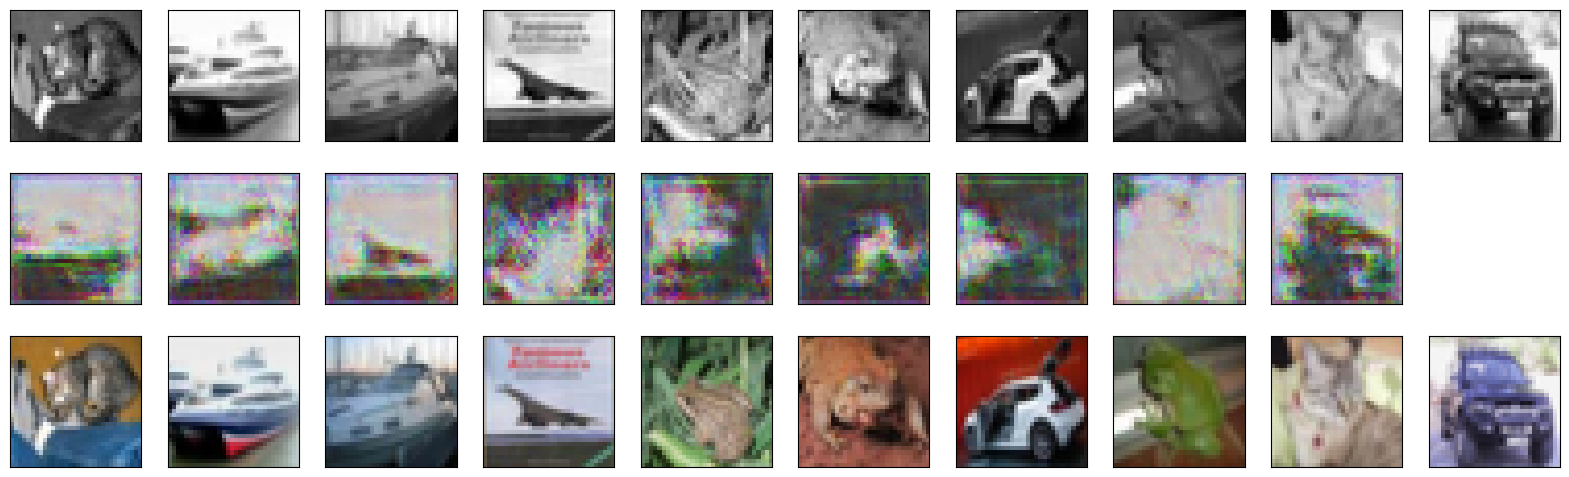

In [27]:
show_images(data, unet)

- 첫번째 : 입력데이터
- 두번째 : 출력데이터
- 세번째 : 정답값